# Normal Inverse Gaussian Process


## Contents
   - [Numerical methods for option pricing](#sec1)
   - [The NIG PIDE method](#sec2)
     - [The Lévy measure](#sec2.1)
     - [The PIDE](#sec2.2) 

The methods used in this notebook are basically the same presented in the notebook **3.2**.     
As you probably have noticed when reading the notebook **1.5**, the NIG process is very similar to the VG process.      They are both obtained by Brownian subordination. They both depend on three variables. Their distribution is quite similar.   

And of course, the numerical methods for option pricing are quite similar as well.

In [1]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import scipy.special as scps
import matplotlib.pyplot as plt
from functools import partial
from scipy.integrate import quad

from FMNM.probabilities import Q1, Q2
from FMNM.CF import cf_NIG

In [2]:
T = 1  # terminal time
N = 10000000  # number of generated random variables
S0 = 100.0  # initial price
K = 100.0  # strike
k = np.log(K / S0)  # log moneyness

r = 0.1
theta = -0.11  # drift of the Brownian motion
sigma = 0.2  # volatility of the Brownian motion
kappa = 0.3  # variance of the IG process
lam = T**2 / kappa  # scale
mu_s = T / lam  # scaled mu

w = (1 - np.sqrt(1 - 2 * theta * kappa - kappa * sigma**2)) / kappa  # Martingale correction
dev_X = np.sqrt(sigma**2 + theta**2 * kappa)  # std dev NIG process

Let me recall the derivation of some formulas:

##### Mean and Variance: 
Using the Brownian subordination expression for the NIG process (where $T_t \sim IG(t,\kappa t)$), we get

$$ \mathbb{E}[X_t] = \mathbb{E}[\theta T_t + \sigma W_{T_t}] = \theta \mathbb{E}[T_t] + 0 = \theta t.$$

where I used the [Tower property](https://en.wikipedia.org/wiki/Law_of_total_expectation), and

$$ \text{Var}[X_t] = \text{Var}[\theta T_t + \sigma W_{T_t}] = \theta^2 \text{Var}[T_t] + 
\sigma^2 \text{Var}[W_{T_t}] = (\theta^2 \kappa + \sigma^2) t. $$

where for the term $\text{Var}[W_{T_t}]$ I used the [conditional variance](https://en.wikipedia.org/wiki/Law_of_total_variance) formula.

##### Martingale correction:

The idea is to find the correction term $w$ such that the process $e^{-rt}S_t$ is a martingale. The stock process has dynamics $S_t = S_0 e^{rt - wt + X_t}$.     
We have that

$$ \mathbb{E}[ e^{-rt} S_0 e^{rt - wt + X_t} ] = S_0$$

$$ \mathbb{E}[ e^{-wt + X_t}] = 1$$

$$ e^{wt} = \mathbb{E}[ e^{X_t}] $$

$$ w = \log( \phi(-i) ) \quad \quad \text{for} \quad t=1  $$

In [3]:
print("The martingale correction w={0:.6f} can be computed from the CF as: ".format(w))
print(np.log(cf_NIG(-1j, t=1, mu=0, theta=theta, sigma=sigma, kappa=kappa)).round(6))

The martingale correction w=-0.088817 can be computed from the CF as: 
(-0.088817+0j)


<a id='sec1'></a>

# Numerical methods

##### Monte Carlo

In [4]:
np.random.seed(seed=42)
IG = ss.invgauss.rvs(mu=mu_s, scale=lam, size=N)  # The IG RV
Norm = ss.norm.rvs(0, 1, N)  # The normal RV
X = theta * IG + sigma * np.sqrt(IG) * Norm  # NIG random vector
S_T = S0 * np.exp((r - w) * T + X)  # exponential dynamics

call_payoff = np.maximum(S_T - K, 0)
put_payoff = np.maximum(K - S_T, 0)
call = np.exp(-r * T) * np.mean(call_payoff)
put = np.exp(-r * T) * np.mean(put_payoff)
call_err = np.exp(-r * T) * ss.sem(call_payoff)
put_err = np.exp(-r * T) * ss.sem(put_payoff)
print("Monte Carlo, call: {}, std err: {}".format(call, call_err))
print("Monte Carlo, put: {}, std_err: {}".format(put, put_err))

Monte Carlo, call: 13.429721691441594, std err: 0.0049326098983063895
Monte Carlo, put: 3.915092184682041, std_err: 0.0025466749195472587


##### Fourier inversion

In [5]:
# function binding
cf_NIG_b = partial(cf_NIG, t=T, mu=r - w, theta=theta, sigma=sigma, kappa=kappa)

# price
call_F = S0 * Q1(k, cf_NIG_b, np.inf) - K * np.exp(-r * T) * Q2(k, cf_NIG_b, np.inf)
put_F = -S0 * (1 - Q1(k, cf_NIG_b, np.inf)) + K * np.exp(-r * T) * (1 - Q2(k, cf_NIG_b, np.inf))

print("Fourier inversion call: ", call_F.round(6))
print("Fourier inversion put: ", put_F.round(6))

Fourier inversion call:  13.427965
Fourier inversion put:  3.911707


<a id='sec2'></a>

# The NIG PIDE method 

<a id='sec2.1'></a>
## Curiosities about the NIG Lévy measure

The NIG process is a pure jump process with triplet $(b,0,\nu)$. (For more information on the Lévy triplet see Appendix **A.3**)

The expression of the drift $b$ in [2] and [3] is given for the parameters:

$$ \beta = \frac{\theta}{\sigma^2}, \quad \quad \alpha = \sqrt{ \beta^2 + \frac{1}{\kappa \sigma^2} } \quad \quad
 \delta = \frac{T \sigma}{\sqrt{\kappa}} $$

and is:

$$ b = \frac{2 \delta \alpha}{\pi} \int_0^1 \sinh(\beta x) K_1(\alpha x) dx $$

The Lévy measure is:

$$ \nu(x) = \frac{C}{|x|} e^{A x} K_1(B|x|) $$

with

$$ A = \frac{\theta}{\sigma^2} \quad B = \frac{\sqrt{\theta^2 + \sigma^2/\kappa}}{\sigma^2} 
\quad C = \frac{\sqrt{\theta^2 + \sigma^2/\kappa}}{\sigma \pi \sqrt{\kappa}} $$

The function $K_1$ is a Bessel function of second kind with 1 degree of freedom.

Let us recall from the Levy processes theory that:

$$ \mathbb{E}[X_t] = t \biggl( b +  \int_{|x|>1} x \nu(dx) \biggr)$$

$$ \text{Var}[X_t] = t \int_{\mathbb{R}} x^2 \nu(dx) $$

Let's verify it is correct:

In [6]:
def NIG_measure(x):
    A = theta / (sigma**2)
    B = np.sqrt(theta**2 + sigma**2 / kappa) / sigma**2
    C = np.sqrt(theta**2 + sigma**2 / kappa) / (np.pi * sigma * np.sqrt(kappa))
    return C / np.abs(x) * np.exp(A * (x)) * scps.kv(1, B * np.abs(x))

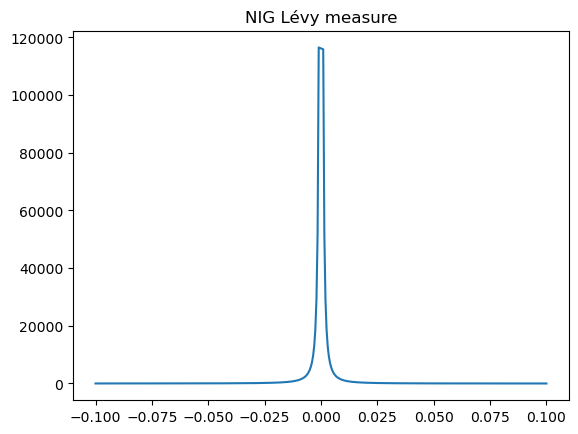

In [7]:
x = np.concatenate((np.linspace(-0.1, -0.001, 200), np.linspace(0.001, 0.1, 200)))
plt.plot(x, NIG_measure(x))
plt.title("NIG Lévy measure")
plt.show()

##### mean:

In [8]:
beta = theta / (sigma**2)
alpha = np.sqrt(beta**2 + 1 / (kappa * sigma**2))
delta = sigma / np.sqrt(kappa)
int_b = lambda y: 2 / np.pi * delta * alpha * np.sinh(beta * y) * scps.kv(1, alpha * np.abs(y))
drift = quad(int_b, 0, 1, points=0, limit=2000)[0]

print("The theoretical mean is theta: ", theta)
print("The drift component is: ", drift)

int_m = lambda y: y * NIG_measure(y)
mean_greater1 = quad(int_m, -10, -1, limit=2000)[0] + quad(int_m, 1, 10, limit=2000)[0]

print("The mean is the sum of the drift and the integration over |x>1| i.e. : ", drift + mean_greater1)

The theoretical mean is theta:  -0.11
The drift component is:  -0.10992734491736125
The mean is the sum of the drift and the integration over |x>1| i.e. :  -0.11000000000015915


##### variance:

In [9]:
int_s = lambda y: y**2 * NIG_measure(y)
var_int = quad(int_s, -2, 2, points=0)[0]  # I inform that the point 0 has a singularity
var_th = dev_X**2
print("The variance obtained from integration of Lévy mesure is: ", round(var_int, 6))
print("The theoretical variance is: ", var_th.round(7))

The variance obtained from integration of Lévy mesure is:  0.04363
The theoretical variance is:  0.04363


##### Martingale correction:

The martingale correction can be computed from the Lévy measure as well:

$$ w = \int_{\mathbb{R} \backslash [-\epsilon,\epsilon]} (e^z-1) \nu(dz). $$

we have to choose an $\epsilon > 0$ very small, but it cannot be zero. The reason is that the NIG process has infinite variation (see **A.3** for the definition) and this means that the integral above does not converge for $\epsilon = 0$. 

**Comment:**     
For infinite variation processes we have that:

$ \int_{[-\epsilon,\epsilon]} (e^z-1) \nu(dz) \approx \int_{[-\epsilon,\epsilon]} z \nu(dz) = \infty. $

This is the main difference with the VG process, which instead has finite variation.

In [10]:
epsilon = 0.0000001
int_w = lambda y: (np.exp(y) - 1) * NIG_measure(y)
w2 = quad(int_w, -10, -epsilon)[0] + quad(int_w, epsilon, 10)[0]
print("Martingale correction: ", w.round(6))
print("Martingale correction from integration: ", round(w2, 6))

Martingale correction:  -0.088817
Martingale correction from integration:  -0.088817


<a id='sec2.2'></a>
## The NIG PIDE

The NIG PIDE is 

$$
\frac{\partial V(t,x)}{\partial t} 
          + \biggl( r - \int_{\mathbb{R}} \bigl( e^z-1-z \mathbb{1}_{|z|<\epsilon} \bigr) \nu(dz) \biggr) \frac{\partial V(t,x)}{\partial x} $$
$$          + \int_{\mathbb{R}} \bigl( V(t,x+z)- V(t,x) - z \frac{\partial V(t,x) }{\partial x} \mathbb{1}_{|z|<\epsilon} \bigr) \nu(dz)  = r V(t,x).
$$

for a small value of $\epsilon$ we can use the Brownian approximation described in **3.2** and **A.3**.      
The jump-diffusion type PIDE is:

$$
  \frac{\partial V(t,x)}{\partial t} +
 \bigl( r-\frac{1}{2}\sigma_{\epsilon}^2 - w_{\epsilon} \bigr) \frac{\partial V(t,x)}{\partial x} 
 + \frac{1}{2}\sigma_{\epsilon}^2 \frac{\partial^2 V(t,x)}{\partial x^2}
 + \int_{|z| \geq \epsilon} V(t,x+z) \nu(dz) = (\lambda_{\epsilon} + r) V(t,x).
$$

with parameters   

$$
  \sigma_{\epsilon}^2 :=  \int_{|z| < \epsilon} z^2 \nu(dz), \quad \quad w_{\epsilon} := \int_{|z| \geq \epsilon} (e^z-1) \nu(dz), \quad \quad
 \lambda_{\epsilon} :=  \int_{|z| \geq \epsilon} \nu(dz) .
$$

The previous approximated equation is identical to the VG equation.     
I'm not repeating the calculation. I'm just going to present some numerical values and some plots.

**Comment:**      
I would like to point out that the convergence to the right price is quite slow, in particular for small values of $\kappa$.     
We have seen a similar behavior for the VG PIDE, but in the NIG PIDE is a bit worse.      
The algorithm works very well for PUT options, while for CALL options it is hard to obtain good results under our grid resolution.    
In order to improve the performances I also used a big computational domain $[A_1,A_2]$, but the improvements are still not satisfactory. 
I expect that for a higher grid resolution (in particular for more time steps), we can achieve better performances.

In [11]:
from FMNM.Parameters import Option_param
from FMNM.Processes import NIG_process
import FMNM.NIG_pricer as NIG

In [12]:
opt_param = Option_param(S0=S0, K=K, T=T, exercise="European", payoff="call")
opt_param2 = Option_param(S0=S0, K=K, T=T, exercise="European", payoff="put")
NIG_param = NIG_process(r=r, sigma=sigma, theta=theta, kappa=kappa)

NIG_c = NIG.NIG_pricer(opt_param, NIG_param)
NIG_p = NIG.NIG_pricer(opt_param2, NIG_param)

##### European Call

In [13]:
NIG_c.PIDE_price((22000, 50000), Time=True)

(13.387236700090668, 46.138726234436035)

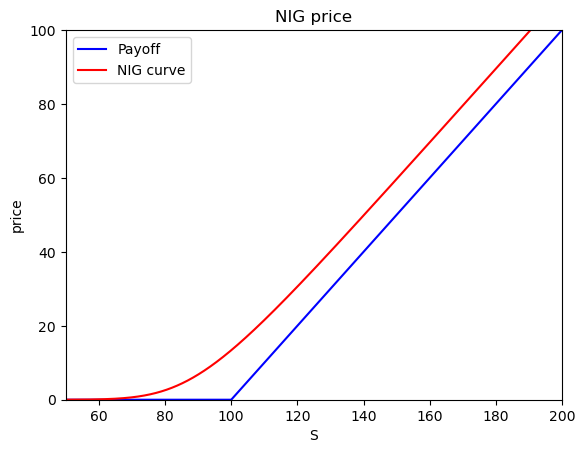

In [14]:
NIG_c.plot([50, 200, 0, 100])

##### European Put

In [15]:
NIG_p.PIDE_price((20000, 30000), Time=True)

(3.9110477337160687, 25.69834804534912)

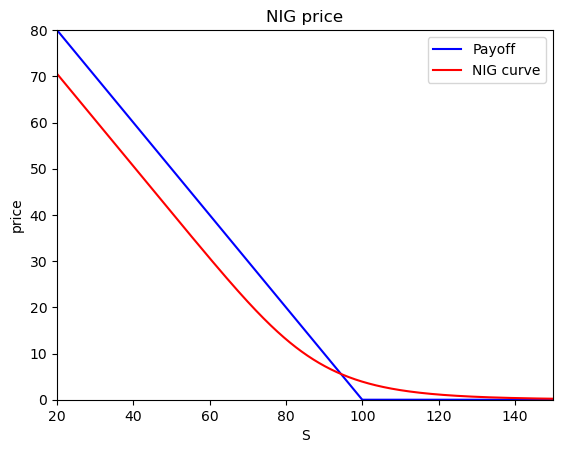

In [16]:
NIG_p.plot([20, 150, 0, 80])

##### American Put

In [17]:
opt_param3 = Option_param(S0=S0, K=K, T=T, exercise="American", payoff="put")
NIG_am = NIG.NIG_pricer(opt_param3, NIG_param)

In [18]:
NIG_am.PIDE_price((10000, 10000), Time=True)

(5.064476059362546, 4.531420946121216)

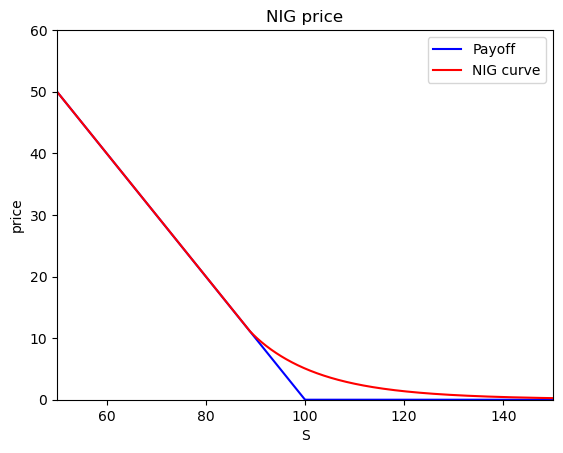

In [19]:
NIG_am.plot([50, 150, 0, 60])

## References

[1] Rama Cont and Peter Tankov (2003) "Financial Modelling with Jump Processes", Chapman and Hall/CRC; 1 edition.  

[2] Rydberg Tina (1997) "The Normal Inverse Gaussian Lévy Process:
Simulation and Approximation",  Communications in Statistics. Stochastic Models. 13:4, 887-910

[3] Barndorff-Nielsen, Ole E. (1998) "Processes of Normal Inverse Gaussian type" Finance and Stochastics 2, 41-68.